# Machine Learning Approaches for News Analysis

By: Michael Vella

The scope of this workbook is to use Support Vector Machine (SVM) model on the features extracted from the two data sets provided, police press releases and news articles.

Dataset used : `data_post_eda.csv`


## SVM in our context:
- Will be focusing on the classification of fatal vs. non-fatal accidents.

## 1. Introduction to the technique

### 1.1 Theory

Support Vector Machines (SVMs) are supervised learning models used primarily for classification and also regression tasks (although used less for regression). The core idea is to find a hyperplane that best separates data points of different classes by maximizing the margin, which is the distance between the hyperplane and the closest points from each class, called support vectors. For linearly inseparable data, SVMs use kernel functions, such as the radial basis function (RBF) or polynomial kernel, to project data into higher-dimensional spaces where a linear separation is possible. SVMs rely on solving a convex optimization problem, which guarantees a unique global solution

### 1.2 Suitability

Support Vector Machines (SVMs) are particularly suitable for classification tasks where the data may be high-dimensional and the number of features exceeds the number of samples. Their ability to find an optimal separating hyperplane by maximizing the margin makes them effective at handling complex decision boundaries, especially when combined with kernel functions for non-linear data. SVMs are also robust in cases where clear distinctions exist between classes and perform well even with small to medium-sized datasets. However, their suitability decreases for extremely large datasets due to computational demands, and careful parameter tuning is required to prevent overfitting or underfitting. Overall, SVMs are well-suited for applications where accuracy and generalization are prioritized, such as image recognition, bioinformatics, and text classification, provided that computational resources and appropriate kernel selection are considered.

## 2. Preprocessing

### 2.1 Installing Packages

In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

### 2.2 Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

### 2.3 Variables

In [3]:
data_folder = "../../data"
final_data_folder = f"{data_folder}/final"

data_csv = f"{final_data_folder}/data_post_eda.csv"

### 2.4 Dataset preparation

In [4]:
df = pd.read_csv(data_csv)

print(f"Dataset shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")
print(f"Dataset info:")
display(df.info())

Dataset shape: (211, 59)
Column names: ['id', 'date_published', 'accident_datetime', 'accident_severity', 'total_injured', 'city', 'street', 'accident_time_category', 'driver_under_18', 'driver_18_to_24', 'driver_25_to_49', 'driver_50_to_64', 'driver_65_plus', 'driver_age_unknown', 'num_drivers_under_18', 'num_drivers_18_to_24', 'num_drivers_25_to_49', 'num_drivers_50_to_64', 'num_drivers_65_plus', 'num_drivers_age_unknown', 'driver_male', 'driver_female', 'driver_gender_unknown', 'num_drivers_male', 'num_drivers_female', 'num_drivers_gender_unknown', 'num_drivers_total', 'vehicle_unknown', 'vehicle_pedestrian', 'vehicle_bicycle', 'vehicle_motorbike', 'vehicle_car', 'vehicle_van', 'vehicle_bus', 'num_vehicle_unknown', 'num_vehicle_pedestrian', 'num_vehicle_bicycle', 'num_vehicle_motorbike', 'num_vehicle_car', 'num_vehicle_van', 'num_vehicle_bus', 'is_weekend', 'is_public_holiday_mt', 'is_school_holiday_mt', 'is_school_day_mt', 'street_type', 'region', 'temperature_max', 'temperature_mi

None

In [5]:
accident_time_categories_df = pd.get_dummies(df["accident_time_category"], drop_first=True, dtype=int)
accident_time_categories_df

,early_morning,evening,late_evening,morning,night
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,0
3,0,0,0,1,0
4,0,0,0,0,0
...,...,...,...,...,...
206,0,0,0,1,0
207,0,0,0,0,1
208,0,0,0,1,0
209,0,0,0,0,0


In [6]:
street_type_categories_df = pd.get_dummies(df["street_type"], drop_first=True, dtype=int)
street_type_categories_df

,primary,residential,secondary,tertiary,trunk
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
206,0,1,0,0,0
207,0,0,0,0,0
208,1,0,0,0,0
209,0,0,0,0,1


In [7]:
region_categories_df = pd.get_dummies(df["region"], drop_first=True, dtype=int)
region_categories_df

,Gozo,Northern,South Eastern,Southern Harbour
0,0,0,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
206,0,1,0,0
207,0,0,0,1
208,0,0,1,0
209,0,0,0,1


In [8]:
final_df = df[[
    "num_drivers_under_18",
    "num_drivers_18_to_24",
    "num_drivers_25_to_49",
    "num_drivers_50_to_64",
    "num_drivers_65_plus",
    "num_drivers_age_unknown",
    "num_drivers_male",
    "num_drivers_female",
    "num_drivers_gender_unknown",
    "num_vehicle_unknown",
    "num_vehicle_pedestrian",
    "num_vehicle_bicycle",
    "num_vehicle_motorbike",
    "num_vehicle_car",
    "num_vehicle_van",
    "num_vehicle_bus",
    "is_weekend",
    "is_school_holiday_mt", # select only this as it is correleated with public holiday/school day booleans
    "temperature_mean", # select only this as highly correleated with other temperature columns
    "is_raining",
    "is_fatal", # target variable
]].join(
    accident_time_categories_df
).join(
    street_type_categories_df
).join(
    region_categories_df
)

final_df["is_weekend"] = final_df['is_weekend'].astype(int)
final_df["is_school_holiday_mt"] = final_df['is_school_holiday_mt'].astype(int)
final_df["is_raining"] = final_df['is_raining'].astype(int)

print("DataFrame before scaling:")
display(final_df)

columns_to_scale = [
    "num_drivers_under_18",
    "num_drivers_18_to_24",
    "num_drivers_25_to_49",
    "num_drivers_50_to_64",
    "num_drivers_65_plus",
    "num_drivers_age_unknown",
    "num_drivers_male",
    "num_drivers_female",
    "num_drivers_gender_unknown",
    "num_vehicle_unknown",
    "num_vehicle_pedestrian",
    "num_vehicle_bicycle",
    "num_vehicle_motorbike",
    "num_vehicle_car",
    "num_vehicle_van",
    "num_vehicle_bus",
    "temperature_mean",
]

scaler = StandardScaler()
final_df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print("DataFrame after scaling:")
display(final_df)

print("Dataset information:")    
final_df.info()

DataFrame before scaling:


,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,num_drivers_gender_unknown,num_vehicle_unknown,...,night,primary,residential,secondary,tertiary,trunk,Gozo,Northern,South Eastern,Southern Harbour
0,0,0,0,0,0,1,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,2,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,0,0,0,0,1,1,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,0,0,0,0,2,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
207,0,0,0,0,0,2,0,0,2,0,...,1,0,0,0,0,0,0,0,0,1
208,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
209,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


DataFrame after scaling:


,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,num_drivers_gender_unknown,num_vehicle_unknown,...,night,primary,residential,secondary,tertiary,trunk,Gozo,Northern,South Eastern,Southern Harbour
0,-0.198517,-0.462876,-0.977677,-0.535974,-0.452432,1.706497,-1.530428,1.304785,-0.466381,-0.097823,...,1,1,0,0,0,0,0,0,0,0
1,-0.198517,-0.462876,0.344694,-0.535974,-0.452432,1.706497,1.253368,-0.607087,-0.466381,-0.097823,...,1,0,1,0,0,0,0,1,0,0
2,-0.198517,-0.462876,-0.977677,-0.535974,1.717184,1.706497,-0.138530,-0.607087,1.463156,-0.097823,...,0,0,0,0,0,1,0,1,0,0
3,-0.198517,-0.462876,0.344694,-0.535974,-0.452432,-0.411567,-1.530428,1.304785,-0.466381,-0.097823,...,0,0,1,0,0,0,0,1,0,0
4,-0.198517,-0.462876,-0.977677,1.448070,-0.452432,-0.411567,-0.138530,-0.607087,-0.466381,-0.097823,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,-0.198517,-0.462876,-0.977677,-0.535974,3.886800,-0.411567,-0.138530,1.304785,-0.466381,-0.097823,...,0,0,1,0,0,0,0,1,0,0
207,-0.198517,-0.462876,-0.977677,-0.535974,-0.452432,3.824561,-1.530428,-0.607087,3.392694,-0.097823,...,1,0,0,0,0,0,0,0,0,1
208,-0.198517,-0.462876,-0.977677,1.448070,1.717184,-0.411567,-0.138530,1.304785,-0.466381,-0.097823,...,0,1,0,0,0,0,0,0,1,0
209,-0.198517,-0.462876,-0.977677,-0.535974,-0.452432,1.706497,-1.530428,-0.607087,1.463156,-0.097823,...,0,0,0,0,0,1,0,0,0,1


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   num_drivers_under_18        211 non-null    float64
 1   num_drivers_18_to_24        211 non-null    float64
 2   num_drivers_25_to_49        211 non-null    float64
 3   num_drivers_50_to_64        211 non-null    float64
 4   num_drivers_65_plus         211 non-null    float64
 5   num_drivers_age_unknown     211 non-null    float64
 6   num_drivers_male            211 non-null    float64
 7   num_drivers_female          211 non-null    float64
 8   num_drivers_gender_unknown  211 non-null    float64
 9   num_vehicle_unknown         211 non-null    float64
 10  num_vehicle_pedestrian      211 non-null    float64
 11  num_vehicle_bicycle         211 non-null    float64
 12  num_vehicle_motorbike       211 non-null    float64
 13  num_vehicle_ca

In [9]:
X = final_df.drop(["is_fatal"], axis=1)
y = final_df["is_fatal"]

In [10]:
# use stratify to make sure that target variable distribution between train/test sets are not imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

print("Training set distribution:")
print(y_train.value_counts())
print("\nTesting set distribution:")
print(y_test.value_counts())

# Relative distribution (percentages)
print("\nTraining set distribution (percent):")
print(y_train.value_counts(normalize=True) * 100)
print("\nTesting set distribution (percent):")
print(y_test.value_counts(normalize=True) * 100)

Training set distribution:
is_fatal
0    146
1     22
Name: count, dtype: int64

Testing set distribution:
is_fatal
0    37
1     6
Name: count, dtype: int64

Training set distribution (percent):
is_fatal
0    86.904762
1    13.095238
Name: proportion, dtype: float64

Testing set distribution (percent):
is_fatal
0    86.046512
1    13.953488
Name: proportion, dtype: float64


## 3. Hyperparameter Tuning

Helpful resources:
1. https://www.kaggle.com/code/prashant111/svm-classifier-tutorial
2. https://www.kaggle.com/code/rajeev102001/svm-support-vector-machine-for-classification
3. https://www.geeksforgeeks.org/machine-learning/optimal-feature-selection-for-support-vector-machines/

### 3.1 Baseline

Let's use the null accuracy as a baseline metric. Null accuracy in machine learning is a baseline metric representing the accuracy achieved by always predicting the most frequent class in a dataset. It serves as a benchmark for evaluating classification models, specifically in imbalanced datasets where a "naive" model might otherwise seem highly accurate.

In [11]:
# calculate null accuracy on test set
null_acc_test = y_test.value_counts().max() / len(y_test)
print(f"Null accuracy value: {null_acc_test}. Achieved by assigning all instances in the test set to the class that has the highest frequency (in this case, the non-fatal class).")

Null accuracy value: 0.8604651162790697. Achieved by assigning all instances in the test set to the class that has the highest frequency (in this case, the non-fatal class).


### 3.2 Train SVM with default parameters

Default hyperparameter means C=1.0, kernel=`rbf` and gamma=`auto` among other parameters.

In [12]:
# instantiate classifier with default hyperparameters
svc=SVC() 

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.8837


### 3.3 Test out different kernels and C values

In [13]:
kernels = ["rbf", "sigmoid", "linear", "poly"]
regularisation = [0.01, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0]

results = []

for kernel in kernels:
    for C in regularisation:
        svc = SVC(C=C, kernel=kernel)
        svc.fit(X_train, y_train)

        y_pred = svc.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, pos_label=1)

        results.append({
            "kernel": kernel,
            "C": C,
            "accuracy": acc,
            "recall": recall
        })

# Convert to DataFrame for easier handling
results_df = pd.DataFrame(results)
print(results_df)

     kernel      C  accuracy    recall
0       rbf   0.01  0.860465  0.000000
1       rbf   0.10  0.860465  0.000000
2       rbf   0.25  0.860465  0.000000
3       rbf   0.50  0.860465  0.000000
4       rbf   1.00  0.883721  0.166667
5       rbf   2.00  0.860465  0.166667
6       rbf   5.00  0.837209  0.166667
7       rbf  10.00  0.883721  0.333333
8   sigmoid   0.01  0.860465  0.000000
9   sigmoid   0.10  0.860465  0.000000
10  sigmoid   0.25  0.860465  0.000000
11  sigmoid   0.50  0.860465  0.000000
12  sigmoid   1.00  0.860465  0.000000
13  sigmoid   2.00  0.837209  0.000000
14  sigmoid   5.00  0.837209  0.000000
15  sigmoid  10.00  0.813953  0.166667
16   linear   0.01  0.860465  0.000000
17   linear   0.10  0.860465  0.000000
18   linear   0.25  0.813953  0.000000
19   linear   0.50  0.720930  0.000000
20   linear   1.00  0.744186  0.166667
21   linear   2.00  0.744186  0.166667
22   linear   5.00  0.720930  0.166667
23   linear  10.00  0.744186  0.166667
24     poly   0.01  0.860

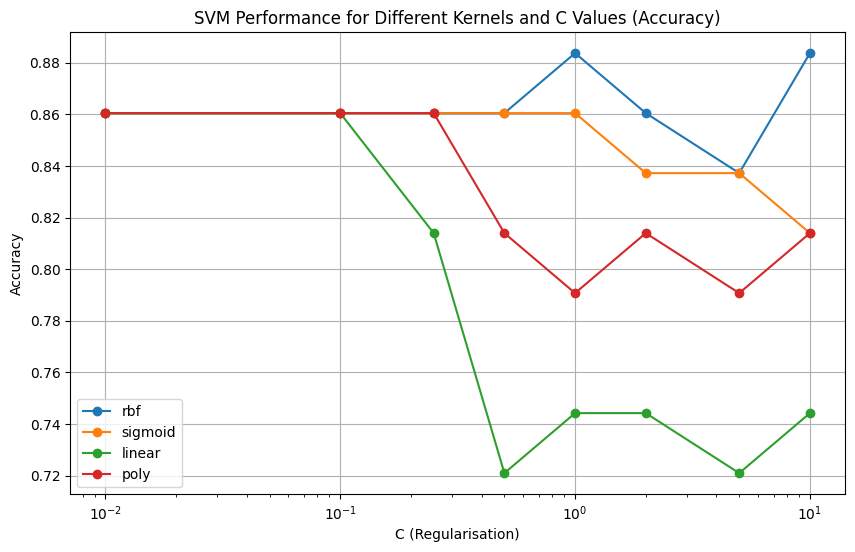

In [14]:
plt.figure(figsize=(10, 6))

for kernel in kernels:
    subset = results_df[results_df["kernel"] == kernel]
    plt.plot(subset["C"], subset["accuracy"], marker='o', label=kernel)

plt.xscale("log")  # very useful for C
plt.xlabel("C (Regularisation)")
plt.ylabel("Accuracy")
plt.title("SVM Performance for Different Kernels and C Values (Accuracy)")
plt.legend()
plt.grid(True)
plt.show()

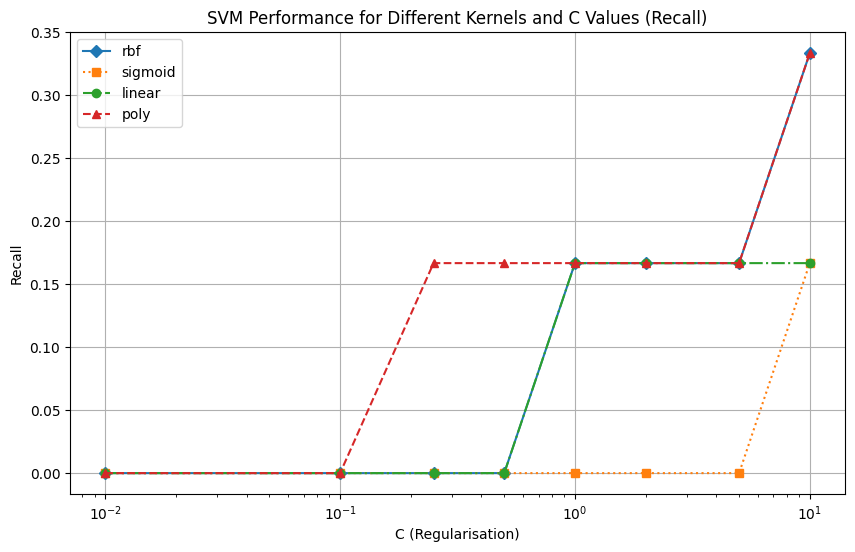

In [15]:
styles = {
    "rbf": {"linestyle": "-", "marker": "D"},
    "sigmoid": {"linestyle": ":", "marker": "s"},
    "linear": {"linestyle": "-.", "marker": "o"},
    "poly": {"linestyle": "--", "marker": "^"},
}

plt.figure(figsize=(10, 6))

for kernel in kernels:
    subset = results_df[results_df["kernel"] == kernel]
    plt.plot(
        subset["C"],
        subset["recall"],
        label=kernel,
        **styles[kernel]
    )

plt.xscale("log")
plt.xlabel("C (Regularisation)")
plt.ylabel("Recall")
plt.title("SVM Performance for Different Kernels and C Values (Recall)")
plt.legend()
plt.grid(True)
plt.show()

## 4. Model Training

Select the best C value and kernel and train on it.

In [16]:
svc=SVC(C=10, kernel='rbf')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print("Model accuracy score with custom hyperparameters (C=10, kernel='rbf'): {0:0.4f}". format(accuracy_score(y_test, y_pred)))
print("Model recall score with custom hyperparameters (C=10, kernel='rbf'): {0:0.4f}". format(recall_score(y_test, y_pred)))

Model accuracy score with custom hyperparameters (C=10, kernel='rbf'): 0.8837
Model recall score with custom hyperparameters (C=10, kernel='rbf'): 0.3333


## 5. Evaluation

### 5.1. Print predicted vs. actual

In [17]:
for i, pred in enumerate(y_pred):
    actual = y_test.iloc[i]
    print(f"Prediction Number: {i + 1}. Predicted: {pred}. Actual: {actual}")

Prediction Number: 1. Predicted: 0. Actual: 1
Prediction Number: 2. Predicted: 0. Actual: 0
Prediction Number: 3. Predicted: 0. Actual: 0
Prediction Number: 4. Predicted: 0. Actual: 0
Prediction Number: 5. Predicted: 0. Actual: 0
Prediction Number: 6. Predicted: 0. Actual: 0
Prediction Number: 7. Predicted: 0. Actual: 0
Prediction Number: 8. Predicted: 0. Actual: 0
Prediction Number: 9. Predicted: 0. Actual: 0
Prediction Number: 10. Predicted: 0. Actual: 0
Prediction Number: 11. Predicted: 0. Actual: 0
Prediction Number: 12. Predicted: 0. Actual: 0
Prediction Number: 13. Predicted: 1. Actual: 1
Prediction Number: 14. Predicted: 1. Actual: 0
Prediction Number: 15. Predicted: 0. Actual: 0
Prediction Number: 16. Predicted: 0. Actual: 1
Prediction Number: 17. Predicted: 0. Actual: 1
Prediction Number: 18. Predicted: 0. Actual: 0
Prediction Number: 19. Predicted: 0. Actual: 0
Prediction Number: 20. Predicted: 0. Actual: 0
Prediction Number: 21. Predicted: 0. Actual: 0
Prediction Number: 22.

### 5.2. Confusion Matrix/Metrics

In [18]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

print('Confusion matrix:', cm)

TP = cm[0,0]
TN = cm[1,1]
FP = cm[1,0]
FN = cm[0,1]

print('True Positives(TP) = ', TP)
print('True Negatives(TN) = ', TN)
print('False Positives(FP) = ', FP)
print('False Negatives(FN) = ', FN)

Confusion matrix: [[ 2  4]
 [ 1 36]]
True Positives(TP) =  2
True Negatives(TN) =  36
False Positives(FP) =  1
False Negatives(FN) =  4


<Axes: >

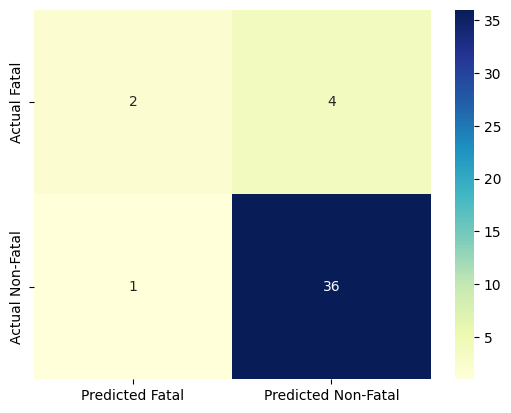

In [19]:
cm_matrix = pd.DataFrame(
    cm,
    index=['Actual Fatal', 'Actual Non-Fatal'],
    columns=['Predicted Fatal', 'Predicted Non-Fatal']
)

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [20]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
classification_error = (FP + FN) / float(TP + TN + FP + FN)
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
specificity = TN / (TN + FP)
f1_score = (2 * precision * recall) / (precision + recall)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))
print('Classification error : {0:0.4f}'.format(classification_error))
print('Precision : {0:0.4f}'.format(precision))
print('Recall or Sensitivity : {0:0.4f}'.format(recall))
print('Specificity : {0:0.4f}'.format(specificity))
print('F1 Score : {0:0.4f}'.format(f1_score))

Classification accuracy : 0.8837
Classification error : 0.1163
Precision : 0.6667
Recall or Sensitivity : 0.3333
Specificity : 0.9730
F1 Score : 0.4444


### 5.3. ROC Score/Curve

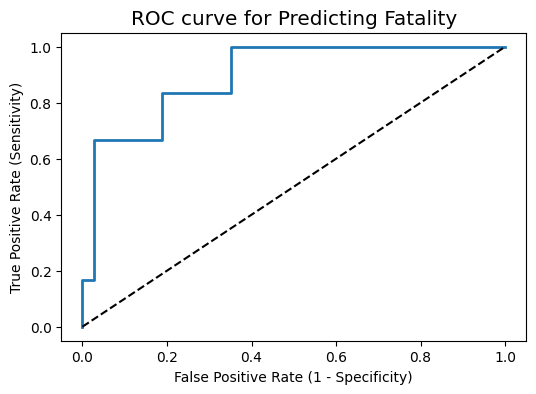

ROC AUC : 0.8964


In [21]:
y_scores = svc.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting Fatality')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC_AUC = roc_auc_score(y_test, y_scores)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

### 5.4. PRC Score/Curve

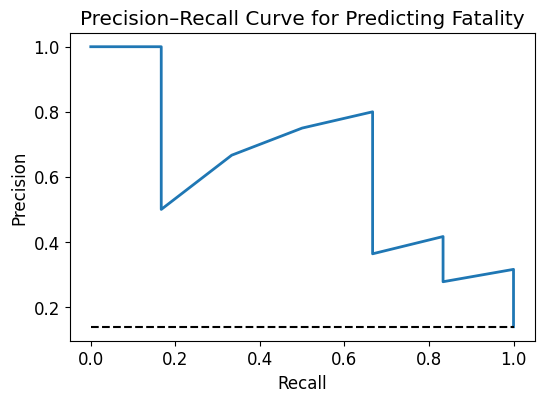

Average Precision (PRC AUC) : 0.6582


In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, linewidth=2)
plt.plot([0,1], [y_test.mean(), y_test.mean()], 'k--')  # baseline
plt.rcParams['font.size'] = 12
plt.title('Precision–Recall Curve for Predicting Fatality')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

AP = average_precision_score(y_test, y_scores)
print('Average Precision (PRC AUC) : {:.4f}'.format(AP))

## 6. Interpretation

The model performs slightly better than the null hypothesis with accuracy of 88.4% and recall of 33.3%.

Given the limited data, these results indicate the model is reliable in predicting the correct classification but not reliable in predicting fatal accidents, making it unreliable for a fatality predictor.

## 7. Limitations and ethical considerations

### 7.1 Limitations:

1. Scalability with Large Datasets: SVMs become computationally expensive for very large datasets.
2. Choice of Kernel: Performance depends on the right Kernel being chosen and tuning it's parameters.
3. Sensitive to outliers: Since they try to maximise the margine, outliers can disproportionately influence the decision boundary.
4. Interpretability: SVMs, particularly with non-linear kernels, are considered black-box models.
5. Focus is on Binary Classification: Can to multi-class classification but requires techniques like one-vs-one or one-vs-rest, which are quite complex.

## 7.2 Ethical considerations:

1. Bias and Fairness: If training data contains some form of bias, SVM will learn these biases.
2. Transparency and Explainability: Might be difficult to explain why a certain result was obtained when needed (for example, healthcare).
3. Privacy.